In [1]:
import pandas as pd
from random import randint, choice, sample
from scipy.stats import binom
from numpy.random import choice
import numpy as np
from time import time as time_
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
dt = pd.read_csv('forecast3.csv', sep=';')
fishs = ['щука', 'судак', 'окунь', 'берш', 'речная форель', 'озерная форель', 'елец', 'чехонь', 'сом', 'голавль', 'язь',
         'карп', 'жерех', 'лещ', 'карась', 'линь', 'пескарь', 'ротан', 'плотва', 'красноперка', 'налим', 'густера',
         'амур', 'ерш', 'сазан', 'подуст', 'толстолобик', 'вобла', 'хариус']
fishs = list(map(lambda x: x.capitalize(), fishs))
# dt = dt.rename(columns={fish: fish.capitalize() for fish in fishs})
dt

,day_temp,day_pressure,day_obl,day_phen,day_dir,day_wind,areal,city,year,month,...,Красноперка,Налим,Густера,Амур,Ерш,Сазан,Подуст,Толстолобик,Вобла,Хариус
0,-4,749,dull,snow,Ю,3,Алтайский край,Барнаул,2020,1,...,0.177273,0.829630,0.588095,0.0,0.441576,0.032261,0.0,0.0,0.185714,0.126996
1,-1,750,dull,-,Ю,5,Алтайский край,Барнаул,2020,1,...,0.151010,0.800000,0.495238,0.0,0.565217,0.020312,0.0,0.0,0.140693,0.077836
2,-3,749,dull,-,Ю,2,Алтайский край,Барнаул,2020,1,...,0.216667,0.829630,0.464286,0.0,0.600543,0.040625,0.0,0.0,0.146320,0.110609
3,-6,753,dull,-,Ю,1,Алтайский край,Барнаул,2020,1,...,0.216667,0.829630,0.464286,0.0,0.423913,0.040625,0.0,0.0,0.146320,0.110609
4,-2,752,suncl,-,Ю,3,Алтайский край,Барнаул,2020,1,...,0.321717,0.622222,0.526190,0.0,0.635870,0.052574,0.0,0.0,0.191342,0.131092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30516,-6,752,dull,-,З,1,Московская область,Щелково,2020,12,...,0.180556,0.362963,0.417857,0.0,0.508696,0.000000,0.0,0.0,0.146320,0.110609
30517,-6,759,sunc,-,ЮВ,1,Московская область,Щелково,2020,12,...,0.235269,0.375926,0.473571,0.0,0.551087,0.000000,0.0,0.0,0.191342,0.147479
30518,-5,754,dull,-,ЮВ,3,Московская область,Щелково,2020,12,...,0.120370,0.116667,0.195000,0.0,0.678261,0.000000,0.0,0.0,0.045022,0.032773
30519,-3,753,dull,-,-,0,Московская область,Щелково,2020,12,...,0.213384,0.259259,0.306429,0.0,0.529891,0.000000,0.0,0.0,0.146320,0.094223


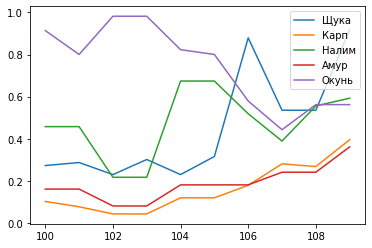

In [4]:
i = 100
dt[i:i + 10][['Щука', 'Карп', 'Налим', 'Амур', 'Окунь']].plot()

In [14]:
class DayGenerator:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.times = [12, 15, 18, 21, 0, 3, 6, 9]
        self.dirs = {
            'С': {'values': ['СЗ', 'СВ'], 'p': [0.2, 0.3]},
            'СЗ': {'values': ['С', 'З'], 'p': [0.25, 0.25]},
            'З': {'values': ['СЗ', 'ЮЗ'], 'p': [0.2, 0.3]},
            'ЮЗ': {'values': ['З', 'Ю'], 'p': [0.25, 0.25]},
            'Ю': {'values': ['ЮЗ', 'ЮВ'], 'p': [0.3, 0.2]},
            'ЮВ': {'values': ['Ю', 'В'], 'p': [0.2, 0.3]},
            'В': {'values': ['СВ', 'ЮВ'], 'p': [0.3, 0.2]},
            'СВ': {'values': ['С', 'В'], 'p': [0.3, 0.2]},
        }
        
        self.phens = {
            'snow': {'values': ['небольшой снег', 'снег', 'снег с дождём', 'сильный снег', 'мокрый снег'], 'p': [0.35, 0.25, 0.15, 0.1, 0.15]},
            'rain': {'values': ['небольшой дождь', 'дождь', 'сильный дождь'], 'p': [0.45, 0.35, 0.2]},
            'storm': {'values': ['небольшой дождь', 'дождь', 'гроза', 'сильный дождь'], 'p': [0.15, 0.25, 0.3, 0.3]},
        }
        
        self.obl = {
            'dull': {'values': ['пасмурно', 'облачно'], 'p': [0.7, 0.3]},
            'suncl': {'values': ['облачно', 'малооблачно', 'пасмурно'], 'p': [0.6, 0.3, 0.1]},
            'sun': {'values': ['ясно', 'малооблачно'], 'p': [0.7, 0.3]},
            'sunc': {'values': ['малооблачно', 'ясно', 'облачно'], 'p': [0.6, 0.2, 0.2]},
        }
        
        self.fishs = ['Щука', 'Судак', 'Окунь', 'Берш', 'Речная форель', 'Озерная форель', 'Елец', 'Чехонь', 'Сом', 'Голавль', 'Язь',
         'Карп', 'Жерех', 'Лещ', 'Карась', 'Линь', 'Пескарь', 'Ротан', 'Плотва', 'Красноперка', 'Налим', 'Густера',
         'Амур', 'Ерш', 'Сазан', 'Подуст', 'Толстолобик', 'Вобла', 'Хариус']
        
    def __getitem__(self, idx):
        day_priew = self.dataframe.iloc[idx - 1]
        day = self.dataframe.iloc[idx]
        day_next = self.dataframe.iloc[idx + 1]
        pressure = ','.join(map(str, self.gen_pressure(day_priew['day_pressure'], day['day_pressure'], day_next['day_pressure'])))
        temperature = ','.join(map(str, self.gen_temperature(day_priew['day_temp'], day['day_temp'], day_next['day_temp'])))
        wind_, gust_ = self.gen_wind(day_priew['day_wind'], day['day_wind'], day_next['day_wind'])
        wind = ','.join(map(str, wind_))
        gust = ','.join(map(str, gust_))
        wind_direction = ','.join(self.gen_dir(day['day_dir']))
        phenomen_= self.gen_phenomen(day['day_obl'], day['day_phen'])
        humidity = ','.join(map(str,self.gen_hum(phenomen_)))
        phenomen = ','.join(phenomen_)
        uv_index = ','.join(map(str,self.gen_uv(day['month'])))
        moon_direction, moon = self.gen_moon(sum(day[fish].item() for fish in self.fishs) / len(self.fishs))
        return {
            'pressure': pressure,
            'temperature': temperature,
            'wind': wind,
            'gust': gust,
            'wind_direction': wind_direction,
            'humidity': humidity,
            'phenomenon': phenomen,
            'uv_index': uv_index,
            'moon_direction': moon_direction,
            'moon': moon,
            'month': day['month'].item(),
            'day': day['day'].item(),
            
        }
        
    def dist_(self, left, right, len_):
        is_revert = False
        if left > right:
            left, right = right, left
            is_revert = True
        result = []
        current = left
        for _ in range(len_ - 1): 
            sub = binom.rvs(right - current, 1 / len_)
            current += sub
            result.append(current)
        result.append(right)
        return result[::-1] if is_revert else result
        
    def gen_pressure(self, pressure_priew, pressure, pressure_next):
        pressure_ = {}
        priew_sub = pressure - pressure_priew
        next_sub = pressure_next - pressure
        current_pressure = pressure_priew
        for time in [15, 18, 21]:
            sub = randint(-2, 0) if priew_sub < 0 else randint(-1, 1)
            current_pressure += sub
        dist = self.dist_(current_pressure, pressure, 5)
        for idx, time in enumerate([0, 3, 6, 9, 12]):
            pressure_.update({time: dist[idx]})
        current_pressure = pressure
        for time in [15, 18, 21]:
            sub = randint(-2, 0) if next_sub < 0 else randint(-1, 1)
            current_pressure += sub
            pressure_.update({time: current_pressure})
        return [pressure_[key] for key in sorted(pressure_)]
    
    def gen_wind(self, wind_priew, wind, wind_next):
        wind_ = {}
        priew_sub = wind - wind_priew
        next_sub = wind_next - wind
        current_wind = randint(0, randint(wind_priew, wind)) if priew_sub > 0 else 0
        dist = self.dist_(current_wind, wind, 5)
        for idx, time in enumerate([0, 3, 6, 9, 12]):
            wind_.update({time: dist[idx]})
        current_wind = wind_[12] + randint(-1, 2)
        current_wind = max(0, current_wind)
        wind_.update({15: current_wind})
        current_wind += randint(-1, 2)
        current_wind = max(0, current_wind)
        wind_.update({18: current_wind})
        current_wind += randint(-3, 0)
        current_wind = max(0, current_wind)
        wind_.update({21: current_wind})
        gust_= {time: wind_[time] + randint(3, 8) for time in self.times}
        return [wind_[key] for key in sorted(wind_)], [gust_[key] for key in sorted(gust_)]
    
    def gen_dir(self,direction):
        dir_ = {}
        if direction == '-':
            direction = choice(list(self.dirs.keys()))
        dist = list(choice([direction] + self.dirs[direction]['values'], 8, p=[0.5] + self.dirs[direction]['p']))
        for idx, time in enumerate(self.times):
            dir_.update({time: dist[idx]})
        return [dir_[key] for key in sorted(dir_)]
    
    def gen_temperature(self, temp_priew, temp, temp_next):
        temp_ = {}
        priew_sub = temp - temp_priew
        next_sub = temp_next - temp
        current_temp = temp_priew
        for time in [15, 18, 21]:
            sub = randint(-3, -1) if priew_sub < 0 else randint(-2, 0)
            current_temp += sub
        dist = self.dist_(current_temp, temp, 5)
        for idx, time in enumerate([0, 3, 6, 9, 12]):
            temp_.update({time: dist[idx]})
        current_temp = temp
        for time in [15, 18, 21]:
            sub = randint(-3, -1) if next_sub < 0 else randint(-2, 0)
            current_temp += sub
            temp_.update({time: current_temp})
        return [temp_[key] for key in sorted(temp_)]
    
    def gen_phenomen(self, obl, phen):
        phens_ = {}
        if obl == '-':
            obl = 'sun'
        dist_olb = list(choice(self.obl[obl]['values'], 8, p=self.obl[obl]['p']))
        if phen == '-':
            for idx, time in enumerate(self.times):
                phens_.update({time: dist_olb[idx]})
            return [phens_[key] for key in sorted(phens_)] 
        dist_phens = list(choice(self.phens[phen]['values'], 8, p=self.phens[phen]['p']))
        for idx, time in enumerate(self.times):
            phens_.update({time: '.'.join((dist_olb[idx], dist_phens[idx]))})
        return [phens_[key] for key in sorted(phens_)]
    
    def gen_hum(self, phens):
        hum_ = []
        current_hum = randint(30, 70)
        for phen in phens:
            if 'дождь' in phen:
                current_hum += randint(0, 20)
                current_hum = min(current_hum, randint(93, 99))
            else:
                current_hum += randint(-10, 5)
                current_hum = max(current_hum, randint(10, 29))
            hum_.append(current_hum)
        return hum_
    
    def gen_uv(self, month):
        uv_ = {}
        if month in [12, 1, 2]:
            uv_ = {0: 0, 3: 0, 6: 0, 9: 0, 12: randint(1, 2), 15: 1, 18: 0, 21:0} 
        elif month in [3, 11, 10, 4]:
            uv_ = {0: 0, 3: 0, 6: 0, 9: 1, 12: randint(2, 3), 15: randint(1, 2), 18: 1, 21: 0}
        elif month in [5, 9]:
            uv_ = {0: 0, 3: 0, 6: randint(0, 1), 9: randint(1, 2), 12: randint(2, 4), 15: randint(2, 3), 18: randint(1, 2), 21: randint(0, 1)}
        else:
            uv_ = {0: 0, 3: 0, 6: randint(1, 2), 9: randint(1, 3), 12: randint(2, 4), 15: randint(1, 3), 18: randint(1, 3), 21: randint(1, 2)}
        return [uv_[key] for key in sorted(uv_)]
    
    def gen_moon(self, forecast):
        if forecast > 0.5:
            return 2* randint(0, 1) - 1, randint(35, 70)
        else:
            if randint(0, 1):
                return 2* randint(0, 1) - 1, randint(0, 35)
            else:
                return 2* randint(0, 1) - 1, randint(70, 99)   

In [15]:
ALONE_KEYS = {'time', 'day', 'month', 'humidity', 'uv_index', 'moon', 'moon_direction'}
DIGIT_KEYS = {'temperature', 'wind', 'gust', 'pressure', 'humidity', 'uv_index'}
CATEGORY_KEYS = {'phenomenon', 'wind_direction'}
MOON_KEYS = {'moon', 'moon_direction'}
SUN_KEYS = {'sun_up', 'sun_down'}
WIND_DIRECTIONS = ['Ю', 'ЮЗ', 'З', 'СЗ', 'С', 'СВ', 'В', 'ЮВ']
PHENOMENONS = ['ясно', 'малооблачно', 'облачно', 'пасмурно', 'небольшой дождь', 'дождь', 'сильный дождь',
               'небольшой снег', 'снег', 'снег с дождём', 'сильный снег', 'гроза', 'мокрый снег']
REGIONS = ['Алтайский край', 'Амурская область', 'Архангельская область', 'Астраханская область',
           'Белгородская область', 'Брянская область', 'Владимирская область', 'Волгоградская область',
           'Вологодская область', 'Воронежская область', 'Еврейская автономная область', 'Забайкальский край',
           'Ивановская область', 'Иркутская область', 'Кабардино-Балкарская республика', 'Калининградская область',
           'Калужская область', 'Камчатский край', 'Карачаево-Черкесская республика', 'Кемеровская область',
           'Кировская область', 'Костромская область', 'Краснодарский край', 'Красноярский край', 'Курганская область',
           'Курская область', 'Ленинградская область', 'Липецкая область', 'Магаданская область', 'Московская область']


num_hours = 8
num_days = 3

def preprocess_(data):
    all_data = {}
    for d in data:
        for key in DIGIT_KEYS:
            temp = list(map(int, d[key].split(',')))
            if key in all_data:
                all_data[key] = all_data[key] + temp
            else:
                all_data[key] = temp
        for key in MOON_KEYS:
            temp = [d[key] for _ in range(num_hours)]
            if key in all_data:
                all_data[key] = all_data[key] + temp
            else:
                all_data[key] = temp
        for key in CATEGORY_KEYS:
            if key in all_data:
                all_data[key] = all_data[key] + d[key].split(',')
            else:
                all_data[key] = d[key].split(',')
        days = [d['day'] for _ in range(num_hours)]
        months = [d['month'] for _ in range(num_hours)]
        if 'day' in all_data:
            all_data['day'] = all_data['day'] + days
        else:
            all_data['day'] = days
        if 'month' in all_data:
            all_data['month'] = all_data['month'] + months
        else:
            all_data['month'] = months
        if 'time' in all_data:
            all_data['time'] = all_data['time'] + list(range(0, num_hours * 3, 3))
        else:
            all_data['time'] = list(range(0, num_hours * 3, 3))
    return all_data

def slice_(data, left_bound, righ_bound):
    slice_data = {
        key: data[key][left_bound: righ_bound] for key in data
    }
    return slice_data

def preprocess_batch_(data):
    vec = {}
    for key in data:
        if key in DIGIT_KEYS and not key in ALONE_KEYS:
            for i in range(len(data[key])):
                key_name = '{}_{}'.format(key, i)
                vec.update({key_name: data[key][i]})
        elif key == 'phenomenon':
            phenomenons_ = [_.split('.') for _ in data[key]]
            for phenomenon in PHENOMENONS:
                for i in range(len(phenomenons_)):
                    key_name = '{}_{}'.format(phenomenon, i)
                    vec.update({key_name: int(phenomenon in phenomenons_[i])})
        elif key == 'wind_direction':
            for wind_direction in WIND_DIRECTIONS:
                for i in range(len(data[key])):
                    key_name = '{}_{}'.format(wind_direction, i)
                    vec.update({key_name: int(wind_direction == data[key][i])})
        elif key == 'month':
            for month in range(1, 13):
                key_name = 'month_{}'.format(month)
                vec.update({key_name: int(month == data[key][-1])})
        elif key == 'time':
            for time in range(0, 24, 3):
                key_name = 'time_{}'.format(time)
                vec.update({key_name: int(time == data[key][-1])})
        elif key == 'moon_direction':
            for moon_direction in [-1, 1]:
                key_name = 'moon_direction_{}'.format(moon_direction)
                vec.update({key_name: int(moon_direction == data[key][-1])})
        elif key in ALONE_KEYS:
            key_name = '{}'.format(key)
            vec.update({key_name: data[key][-1]})
    return vec

def gen_forecast(forecast, time, fish):
    if fish in ['Сом', 'Налим']:
        if time == 21:
            return forecast * 1.1
        elif time == 6:
            return forecast * 1.1
        elif time in [0, 3]:
            return forecast * 1.5
        else:
            return forecast * 0.7
    if time in [6, 18]:
        return forecast * 1.3
    elif time == 9:
        return forecast * 1.2
    elif time == 12:
        return forecast * 1.1
    elif time == 15:
        return forecast * 1.0
    else:
        return forecast * 0.7  

In [16]:
gen = DayGenerator(dt)

In [18]:
init_ = False
train_dt = pd.DataFrame()
train_data = []
for idx, row in tqdm(dt.iterrows(), total=1300):
    if idx >= 1300:
        break
    if idx <= 3:
        continue
    data = dt[idx - 3: idx + 1]
    day = gen[idx]
    print(day)
#     day_1 = gen[idx - 1]
#     day_2 = gen[idx - 2]
#     day_3 = gen[idx - 3]
#     print(day)
#     all_data = preprocess_([day_3, day_2, day_1, day])
#     len_data = len(all_data['moon'])
#     probs = {fish: [] for fish in gen.fishs}
#     for i in range(num_hours * num_days + 1, len_data + 1):
#         slice_data = slice_(all_data, i - num_hours * num_days, i)
#         vec = preprocess_batch_(slice_data)
#         for fish in gen.fishs:
#             for fish_ in gen.fishs:
#                 vec.update({fish_: int(fish_ == fish)})
#             time = 0
#             for j in range(0, 24, 3):
#                 if vec['time_{}'.format(j)] == 1:
#                     time = j
#                     break
#             vec = {key: vec[key] for key in sorted(vec)}
#             forecast = gen_forecast(row[fish], time, fish)
#             vec.update({'forecast': forecast})
#             train_data.append(deepcopy(vec))
#     if not init_:
#         train_dt = pd.DataFrame(train_data)
#         train_data = []
#         init_ = True
#         continue
#     train_dt = pd.concat([train_dt, pd.DataFrame(train_data)], ignore_index=True)
#     train_data = []
        

{'pressure': '751,751,751,752,752,753,753,752', 'temperature': '-8,-8,-7,-7,-2,-5,-8,-11', 'wind': '0,0,0,1,3,2,2,1', 'gust': '7,4,6,9,7,10,7,8', 'wind_direction': 'ЮЗ,ЮЗ,ЮЗ,Ю,ЮВ,Ю,Ю,ЮЗ', 'humidity': '39,35,26,27,30,28,32,25', 'phenomenon': 'облачно,облачно,пасмурно,малооблачно,облачно,облачно,облачно,пасмурно', 'uv_index': '0,0,0,0,2,1,0,0', 'moon_direction': -1, 'moon': 22, 'month': 1, 'day': 5}
{'pressure': '752,752,752,752,752,752,753,753', 'temperature': '-5,-6,-6,-6,-6,-10,-11,-13', 'wind': '0,0,0,0,0,1,1,0', 'gust': '8,8,8,4,7,5,9,7', 'wind_direction': 'С,З,С,З,СЗ,С,З,СЗ', 'humidity': '59,54,57,55,57,51,56,49', 'phenomenon': 'ясно,ясно,ясно,ясно,ясно,ясно,малооблачно,ясно', 'uv_index': '0,0,0,0,1,1,0,0', 'moon_direction': 1, 'moon': 95, 'month': 1, 'day': 6}
{'pressure': '753,753,755,755,755,755,755,754', 'temperature': '-13,-13,-13,-13,-13,-14,-15,-16', 'wind': '1,1,1,1,1,0,1,0', 'gust': '7,8,5,9,5,8,9,5', 'wind_direction': 'Ю,Ю,Ю,Ю,Ю,ЮВ,ЮЗ,ЮВ', 'humidity': '26,22,23,14,19,23,1

{'pressure': '756,756,756,756,758,756,755,754', 'temperature': '-6,-5,-4,-4,-2,-4,-6,-7', 'wind': '2,2,2,2,2,4,6,5', 'gust': '10,6,10,10,8,9,11,8', 'wind_direction': 'ЮЗ,ЮЗ,Ю,ЮЗ,ЮЗ,ЮЗ,З,З', 'humidity': '39,33,32,35,30,26,23,27', 'phenomenon': 'ясно,малооблачно,облачно,малооблачно,малооблачно,малооблачно,малооблачно,малооблачно', 'uv_index': '0,0,0,0,2,1,0,0', 'moon_direction': -1, 'moon': 29, 'month': 2, 'day': 17}
{'pressure': '755,755,755,755,755,754,754,754', 'temperature': '-6,-6,-6,-6,-6,-7,-9,-10', 'wind': '1,1,1,1,3,3,5,5', 'gust': '6,9,5,6,6,10,13,8', 'wind_direction': 'ЮЗ,Ю,ЮЗ,ЮЗ,Ю,ЮЗ,ЮВ,ЮЗ', 'humidity': '29,32,35,29,33,36,31,21', 'phenomenon': 'облачно.снег,пасмурно.небольшой снег,пасмурно.небольшой снег,пасмурно.небольшой снег,пасмурно.снег,пасмурно.небольшой снег,пасмурно.небольшой снег,пасмурно.небольшой снег', 'uv_index': '0,0,0,0,1,1,0,0', 'moon_direction': -1, 'moon': 18, 'month': 2, 'day': 18}
{'pressure': '753,752,752,751,751,749,750,750', 'temperature': '-9,-9,-9,-8,

{'pressure': '757,758,759,759,761,762,762,761', 'temperature': '-5,-5,-5,-6,-6,-6,-7,-7', 'wind': '2,2,2,2,3,2,3,1', 'gust': '9,8,8,10,8,8,10,9', 'wind_direction': 'С,С,З,СЗ,СЗ,СЗ,З,СЗ', 'humidity': '60,55,54,46,39,32,30,22', 'phenomenon': 'малооблачно,малооблачно,малооблачно,малооблачно,малооблачно,малооблачно,малооблачно,малооблачно', 'uv_index': '0,0,0,1,2,2,1,0', 'moon_direction': -1, 'moon': 32, 'month': 3, 'day': 24}
{'pressure': '760,760,761,762,764,764,764,764', 'temperature': '-6,-5,-5,-5,-4,-6,-6,-6', 'wind': '0,2,2,2,3,3,4,3', 'gust': '8,8,5,5,10,9,10,11', 'wind_direction': 'Ю,ЮЗ,З,Ю,З,Ю,З,З', 'humidity': '35,26,22,20,19,19,16,15', 'phenomenon': 'малооблачно,малооблачно,малооблачно,ясно,ясно,ясно,ясно,ясно', 'uv_index': '0,0,0,1,3,1,1,0', 'moon_direction': 1, 'moon': 4, 'month': 3, 'day': 25}
{'pressure': '761,761,760,760,760,758,756,755', 'temperature': '-6,-6,-4,-4,0,0,-2,-3', 'wind': '1,1,1,2,4,5,6,6', 'gust': '7,7,9,9,11,13,10,10', 'wind_direction': 'ЮЗ,ЮЗ,Ю,Ю,З,З,ЮЗ,ЮЗ'

{'pressure': '750,750,750,750,752,752,750,748', 'temperature': '11,11,13,15,16,15,15,15', 'wind': '1,1,1,1,2,3,3,0', 'gust': '5,6,4,7,9,9,9,8', 'wind_direction': 'С,СЗ,СВ,С,СВ,СВ,СЗ,С', 'humidity': '55,48,51,55,49,50,54,48', 'phenomenon': 'ясно,ясно,ясно,ясно,ясно,ясно,ясно,ясно', 'uv_index': '0,0,0,1,2,1,1,0', 'moon_direction': 1, 'moon': 42, 'month': 4, 'day': 26}
{'pressure': '747,747,747,747,746,745,745,745', 'temperature': '18,18,19,19,20,20,18,17', 'wind': '0,1,2,2,2,2,3,2', 'gust': '3,5,7,10,9,6,7,6', 'wind_direction': 'С,СЗ,СВ,С,С,С,СВ,СЗ', 'humidity': '39,44,40,33,24,22,28,29', 'phenomenon': 'ясно,ясно,ясно,ясно,ясно,малооблачно,малооблачно,ясно', 'uv_index': '0,0,0,1,3,2,1,0', 'moon_direction': -1, 'moon': 75, 'month': 4, 'day': 27}
{'pressure': '745,741,740,739,737,737,735,733', 'temperature': '20,22,22,23,27,24,23,22', 'wind': '1,1,1,1,3,4,6,4', 'gust': '6,4,5,5,7,7,9,8', 'wind_direction': 'ЮВ,В,В,ЮВ,ЮВ,В,Ю,В', 'humidity': '58,56,49,47,42,39,38,38', 'phenomenon': 'ясно,мало

{'pressure': '738,738,738,738,738,737,737,737', 'temperature': '21,22,24,24,26,25,24,21', 'wind': '1,2,3,3,4,3,3,3', 'gust': '4,9,8,6,7,10,11,6', 'wind_direction': 'ЮЗ,СЗ,ЮЗ,З,З,СЗ,ЮЗ,З', 'humidity': '35,38,40,42,37,29,30,23', 'phenomenon': 'малооблачно,малооблачно,малооблачно,малооблачно,малооблачно,малооблачно,малооблачно,облачно', 'uv_index': '0,0,1,1,3,1,2,2', 'moon_direction': 1, 'moon': 65, 'month': 6, 'day': 2}
{'pressure': '740,741,741,741,743,741,740,739', 'temperature': '22,21,20,20,20,17,16,15', 'wind': '2,2,2,2,2,2,1,1', 'gust': '8,5,7,6,8,8,5,9', 'wind_direction': 'СЗ,СЗ,С,СЗ,С,СЗ,СЗ,З', 'humidity': '25,25,24,24,29,34,36,35', 'phenomenon': 'пасмурно,пасмурно,пасмурно,облачно,облачно,пасмурно,пасмурно,пасмурно', 'uv_index': '0,0,2,1,2,1,1,1', 'moon_direction': 1, 'moon': 54, 'month': 6, 'day': 3}
{'pressure': '739,739,739,739,740,741,740,740', 'temperature': '13,14,15,16,18,16,15,13', 'wind': '0,0,0,2,2,1,3,0', 'gust': '5,4,5,7,8,5,9,6', 'wind_direction': 'С,СЗ,З,З,З,СЗ,С,С

{'pressure': '737,737,737,737,739,738,737,737', 'temperature': '21,23,24,25,27,26,25,24', 'wind': '0,0,1,1,2,3,2,2', 'gust': '4,5,9,9,10,10,10,5', 'wind_direction': 'ЮВ,ЮВ,ЮВ,В,ЮВ,В,ЮВ,ЮВ', 'humidity': '39,40,44,46,41,43,34,35', 'phenomenon': 'пасмурно,пасмурно,пасмурно,пасмурно,пасмурно,облачно,пасмурно,пасмурно', 'uv_index': '0,0,1,1,2,2,3,2', 'moon_direction': -1, 'moon': 60, 'month': 7, 'day': 4}
{'pressure': '736,736,736,736,737,738,739,739', 'temperature': '24,25,25,25,26,24,22,21', 'wind': '0,1,1,1,2,2,4,2', 'gust': '4,4,8,7,9,7,7,6', 'wind_direction': 'В,В,Ю,Ю,ЮВ,В,ЮВ,В', 'humidity': '42,37,42,44,45,42,33,31', 'phenomenon': 'ясно,облачно,малооблачно,облачно,малооблачно,ясно,малооблачно,малооблачно', 'uv_index': '0,0,2,2,4,3,1,2', 'moon_direction': 1, 'moon': 57, 'month': 7, 'day': 5}
{'pressure': '740,739,739,739,738,736,735,734', 'temperature': '21,21,21,21,23,23,23,22', 'wind': '0,0,0,0,1,0,1,0', 'gust': '5,3,7,5,7,5,7,3', 'wind_direction': 'СЗ,З,З,ЮЗ,ЮЗ,З,З,ЮЗ', 'humidity': 

{'pressure': '734,734,734,734,734,734,735,734', 'temperature': '25,25,27,27,31,28,26,23', 'wind': '0,1,1,2,2,4,5,4', 'gust': '7,4,7,9,6,7,12,8', 'wind_direction': 'ЮВ,Ю,В,ЮВ,ЮВ,ЮВ,ЮВ,В', 'humidity': '54,54,47,37,39,39,39,34', 'phenomenon': 'малооблачно,облачно,облачно,облачно,облачно,облачно,малооблачно,облачно', 'uv_index': '0,0,1,1,2,1,2,1', 'moon_direction': -1, 'moon': 62, 'month': 8, 'day': 11}
{'pressure': '735,735,735,735,735,733,733,734', 'temperature': '22,21,20,20,19,18,17,17', 'wind': '0,0,0,1,2,2,3,2', 'gust': '3,3,3,5,8,8,7,8', 'wind_direction': 'В,В,В,В,ЮВ,ЮВ,ЮВ,ЮВ', 'humidity': '60,62,78,89,94,94,94,95', 'phenomenon': 'облачно.сильный дождь,пасмурно.гроза,пасмурно.сильный дождь,облачно.дождь,пасмурно.небольшой дождь,облачно.сильный дождь,пасмурно.дождь,облачно.дождь', 'uv_index': '0,0,2,2,2,1,2,2', 'moon_direction': -1, 'moon': 41, 'month': 8, 'day': 12}
{'pressure': '733,733,733,733,735,734,733,732', 'temperature': '17,17,18,19,19,18,18,18', 'wind': '3,3,3,3,4,5,7,4', '

{'pressure': '749,749,749,749,749,748,746,745', 'temperature': '16,18,18,18,21,20,19,19', 'wind': '0,0,0,1,2,2,3,2', 'gust': '6,7,8,6,10,10,8,5', 'wind_direction': 'ЮЗ,ЮЗ,Ю,ЮВ,Ю,ЮЗ,ЮЗ,Ю', 'humidity': '24,24,25,18,16,15,23,13', 'phenomenon': 'малооблачно,ясно,ясно,малооблачно,малооблачно,малооблачно,малооблачно,малооблачно', 'uv_index': '0,0,0,2,2,2,1,1', 'moon_direction': 1, 'moon': 49, 'month': 9, 'day': 20}
{'pressure': '745,742,742,742,742,740,740,740', 'temperature': '18,19,21,21,25,22,20,17', 'wind': '1,2,3,3,3,5,5,3', 'gust': '5,9,10,10,10,9,12,11', 'wind_direction': 'ЮВ,Ю,ЮЗ,Ю,ЮЗ,ЮЗ,ЮЗ,ЮВ', 'humidity': '58,50,43,48,44,44,40,44', 'phenomenon': 'ясно,ясно,ясно,малооблачно,малооблачно,ясно,ясно,ясно', 'uv_index': '0,0,0,2,4,2,2,0', 'moon_direction': -1, 'moon': 90, 'month': 9, 'day': 21}
{'pressure': '744,744,744,744,746,744,744,742', 'temperature': '20,18,18,18,16,14,13,11', 'wind': '3,4,4,4,6,8,7,7', 'gust': '6,8,11,9,13,15,12,11', 'wind_direction': 'ЮЗ,З,ЮЗ,З,ЮЗ,ЮЗ,З,Ю', 'humidi

{'pressure': '742,742,743,744,745,746,746,745', 'temperature': '7,3,3,3,3,1,-1,-2', 'wind': '2,3,3,4,7,8,8,7', 'gust': '6,9,6,9,10,14,12,12', 'wind_direction': 'Ю,З,Ю,Ю,ЮЗ,ЮЗ,ЮЗ,З', 'humidity': '59,57,51,42,43,34,31,35', 'phenomenon': 'пасмурно,пасмурно,облачно,облачно,облачно,облачно,пасмурно,пасмурно', 'uv_index': '0,0,0,1,3,2,1,0', 'moon_direction': 1, 'moon': 33, 'month': 10, 'day': 28}
{'pressure': '749,750,752,753,756,755,753,752', 'temperature': '-3,-3,-2,-2,-2,-2,-4,-4', 'wind': '1,3,5,5,6,6,5,2', 'gust': '9,8,10,11,14,13,11,5', 'wind_direction': 'ЮЗ,З,ЮЗ,Ю,ЮЗ,ЮЗ,З,ЮЗ', 'humidity': '61,51,42,41,40,40,36,27', 'phenomenon': 'облачно,облачно,пасмурно,пасмурно,пасмурно,облачно,облачно,облачно', 'uv_index': '0,0,0,1,3,2,1,0', 'moon_direction': -1, 'moon': 96, 'month': 10, 'day': 29}
{'pressure': '752,752,752,752,753,754,754,755', 'temperature': '-6,-5,-5,-4,1,0,-2,-3', 'wind': '1,1,1,1,5,7,7,4', 'gust': '6,6,9,8,12,12,11,8', 'wind_direction': 'Ю,Ю,Ю,З,ЮЗ,ЮЗ,З,З', 'humidity': '44,46,

{'pressure': '758,758,758,759,760,761,762,762', 'temperature': '-6,-6,-5,-5,-4,-5,-8,-10', 'wind': '0,1,1,1,2,1,3,1', 'gust': '4,6,5,9,7,4,6,5', 'wind_direction': 'СЗ,СЗ,СЗ,С,З,З,З,С', 'humidity': '58,57,58,60,56,47,52,42', 'phenomenon': 'пасмурно.снег,пасмурно.небольшой снег,пасмурно.небольшой снег,облачно.снег,пасмурно.небольшой снег,пасмурно.снег с дождём,пасмурно.небольшой снег,пасмурно.небольшой снег', 'uv_index': '0,0,0,1,3,2,1,0', 'moon_direction': 1, 'moon': 1, 'month': 11, 'day': 24}
{'pressure': '761,761,761,761,762,761,760,759', 'temperature': '-8,-7,-7,-7,-6,-8,-10,-11', 'wind': '0,0,0,0,1,3,4,2', 'gust': '8,6,8,3,4,7,9,5', 'wind_direction': 'ЮЗ,Ю,Ю,ЮВ,Ю,ЮЗ,Ю,Ю', 'humidity': '59,59,63,65,70,71,61,55', 'phenomenon': 'пасмурно,пасмурно,облачно,пасмурно,облачно,облачно,пасмурно,пасмурно', 'uv_index': '0,0,0,1,3,2,1,0', 'moon_direction': -1, 'moon': 29, 'month': 11, 'day': 25}
{'pressure': '761,762,762,762,762,762,762,762', 'temperature': '-12,-9,-9,-9,-7,-8,-8,-8', 'wind': '1,

{'pressure': '755,755,755,755,755,753,752,750', 'temperature': '-13,-11,-11,-9,-9,-11,-12,-13', 'wind': '0,1,1,1,2,3,4,2', 'gust': '3,8,7,9,9,10,8,10', 'wind_direction': 'ЮЗ,Ю,ЮЗ,Ю,Ю,Ю,ЮЗ,ЮЗ', 'humidity': '60,59,53,53,52,45,40,39', 'phenomenon': 'ясно,малооблачно,малооблачно,ясно,малооблачно,малооблачно,малооблачно,ясно', 'uv_index': '0,0,0,0,2,1,0,0', 'moon_direction': -1, 'moon': 71, 'month': 12, 'day': 18}
{'pressure': '751,751,751,751,751,751,750,750', 'temperature': '-10,-10,-10,-8,-5,-6,-8,-9', 'wind': '2,2,2,2,4,4,6,5', 'gust': '10,10,9,8,9,7,13,11', 'wind_direction': 'ЮЗ,Ю,ЮЗ,З,З,Ю,ЮЗ,ЮЗ', 'humidity': '41,34,24,27,28,29,22,27', 'phenomenon': 'пасмурно,пасмурно,пасмурно,облачно,пасмурно,облачно,облачно,облачно', 'uv_index': '0,0,0,0,1,1,0,0', 'moon_direction': 1, 'moon': 76, 'month': 12, 'day': 19}
{'pressure': '750,747,747,747,747,744,743,744', 'temperature': '-6,-5,-5,-5,-3,-5,-7,-8', 'wind': '1,2,2,2,3,3,4,3', 'gust': '9,8,10,8,7,11,7,9', 'wind_direction': 'Ю,ЮВ,Ю,ЮЗ,ЮВ,Ю,ЮЗ,

{'pressure': '742,742,743,743,744,743,743,744', 'temperature': '-12,-11,-10,-9,-6,-8,-8,-8', 'wind': '0,1,1,1,2,4,6,6', 'gust': '3,4,6,6,10,10,11,14', 'wind_direction': 'Ю,ЮВ,Ю,ЮВ,Ю,ЮВ,Ю,ЮЗ', 'humidity': '43,44,47,42,43,38,32,35', 'phenomenon': 'пасмурно.снег,пасмурно.снег,облачно.небольшой снег,пасмурно.небольшой снег,пасмурно.небольшой снег,пасмурно.снег,пасмурно.небольшой снег,пасмурно.небольшой снег', 'uv_index': '0,0,0,0,2,1,0,0', 'moon_direction': -1, 'moon': 2, 'month': 1, 'day': 13}
{'pressure': '744,744,744,744,748,749,749,748', 'temperature': '-9,-9,-9,-7,-6,-7,-8,-9', 'wind': '0,1,1,2,2,3,2,0', 'gust': '3,6,7,6,6,11,8,8', 'wind_direction': 'ЮЗ,ЮЗ,ЮЗ,ЮЗ,ЮЗ,З,Ю,ЮЗ', 'humidity': '34,29,31,24,26,26,24,15', 'phenomenon': 'облачно,облачно,малооблачно,облачно,облачно,пасмурно,облачно,облачно', 'uv_index': '0,0,0,0,1,1,0,0', 'moon_direction': 1, 'moon': 23, 'month': 1, 'day': 14}
{'pressure': '748,748,748,748,748,748,747,746', 'temperature': '-13,-12,-11,-10,-7,-7,-7,-8', 'wind': '0

KeyboardInterrupt: 

In [48]:
train_dt.describe()

,day,gust_0,gust_1,gust_10,gust_11,gust_12,gust_13,gust_14,gust_15,gust_16,...,ясно_22,ясно_23,ясно_3,ясно_4,ясно_5,ясно_6,ясно_7,ясно_8,ясно_9,forecast
count,300672.000000,300672.000000,300672.000000,300672.000000,300672.000000,300672.000000,300672.00000,300672.000000,300672.000000,300672.000000,...,300672.000000,300672.000000,300672.000000,300672.00000,300672.000000,300672.000000,300672.000000,300672.000000,300672.000000,300672.000000
mean,15.716049,8.090856,8.088156,8.071952,8.065490,8.066069,8.05787,8.066551,8.076968,8.092400,...,0.251929,0.251929,0.256752,0.25434,0.254244,0.255691,0.255498,0.256366,0.254823,0.414833
std,8.774869,2.901360,2.910438,2.917933,2.924375,2.923109,2.92775,2.941239,2.943542,2.939228,...,0.434121,0.434121,0.436842,0.43549,0.435436,0.436249,0.436141,0.436627,0.435762,0.320091
min,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.156481
50%,16.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.363409
75%,23.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.610278
max,31.000000,24.000000,24.000000,23.000000,23.000000,23.000000,23.00000,24.000000,24.000000,24.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.950000


In [49]:
train_dt.to_csv('train_dt.csv', sep=';', index=False)